In [1]:
import os
import numpy as np
import matplotlib.pyplot as plt
from matplotlib import cm
%matplotlib inline

from plotting import plot_utils, summary_plots, load_fits, plot_prf_params
plot_utils.set_all_font_sizes(20)
from utils import roi_utils, default_paths, stats_utils

In [5]:
# Load results of the fitting procedure

# subjects = np.arange(1,9)
# subjects = [6,7,8]
subjects=[1,2,3,4,5,6,7,8]
n_subjects = len(subjects)

fitting_type = 'full_midlevel_plus_alexnet_best_layer_pca'

out = [load_fits.load_fit_results(subject=ss, fitting_type=fitting_type, n_from_end=0, verbose=True) \
       for ss in subjects]
fig_save_folder=None

# initialize roi_def objects to get roi indices
skip_inds = [4,5,7,11,12, 19,20, 22, 24]
roi_def = roi_utils.multi_subject_roi_def(subjects, skip_areas=skip_inds)
roi_names =roi_def.roi_names
n_rois = roi_def.n_rois


loading from /user_data/mmhender/imStat/model_fits/S01/full_midlevel_plus_alexnet_best_layer_pca/Feb-05-2022_2208_06/all_fit_params.npy

dict_keys(['subject', 'volume_space', 'fitting_types', 'voxel_mask', 'brain_nii_shape', 'image_order', 'voxel_index', 'voxel_roi', 'voxel_ncsnr', 'which_prf_grid', 'models', 'best_losses', 'best_lambdas', 'best_params', 'lambdas', 'val_cc', 'val_r2', 'partial_masks', 'partial_version_names', 'zscore_features', 'ridge', 'debug', 'up_to_sess', 'single_sess', 'shuff_rnd_seed', 'use_precomputed_prfs', 'saved_prfs_fn', 'best_layer_each_voxel', 'saved_best_layer_fn', 'voxel_subset_is_done_trn', 'voxel_subset_is_done_val', 'use_pca_st_feats', 'use_pca_pyr_feats_hl', 'pyramid_feature_info', 'group_all_hl_feats', 'n_ori_gabor', 'n_sf_gabor', 'gabor_nonlin_fn', 'alexnet_layer_name', 'alexnet_padding_mode', 'use_pca_alexnet_feats'])
loading from /user_data/mmhender/imStat/model_fits/S02/full_midlevel_plus_alexnet_best_layer_pca/Feb-25-2022_1223_48/all_fit_params

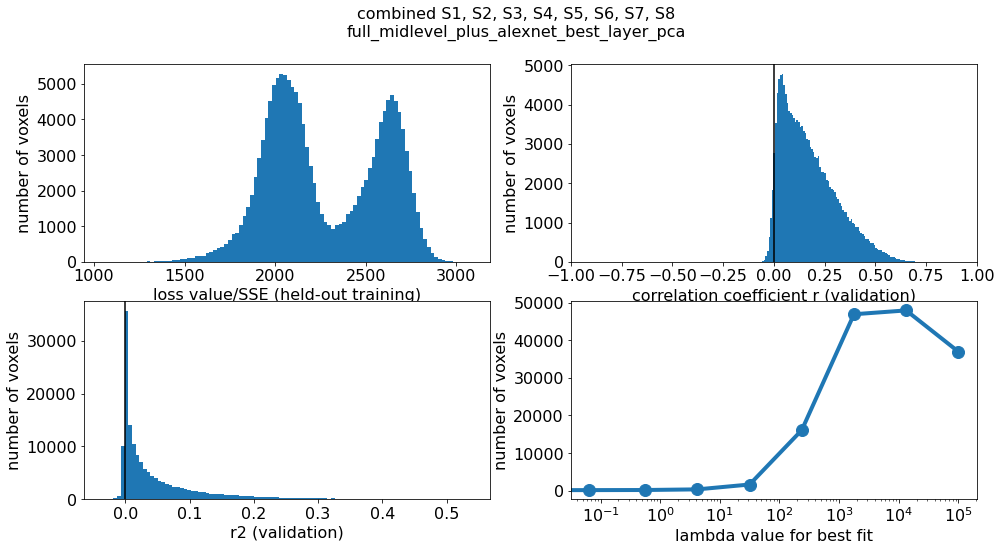

In [12]:
summary_plots.plot_perf_summary(fitting_type, out)

In [6]:
for ii in range(n_subjects):
    print(out[ii]['voxel_subset_is_done_val'])

[ True  True  True  True  True]
[ True  True  True  True  True]
[ True  True  True  True  True]
[ True  True  True  True  True]
[ True  True  True  True  True]
[ True  True  True  True  True]
[ True  True  True  True  True]
[ True  True  True  True  True]


In [7]:
for ii in range(n_subjects):
    print(out[ii]['voxel_subset_is_done_trn'])

[ True  True  True  True  True]
[ True  True  True  True  True]
[ True  True  True  True  True]
[ True  True  True  True  True]
[ True  True  True  True  True]
[ True  True  True  True  True]
[ True  True  True  True  True]
[ True  True  True  True  True]


In [8]:
np.array(out[0]['partial_version_names'])

array(['full_combined_model', 'just_gabor_solo', 'leave_out_gabor_solo',
       'just_pyramid_texture', 'leave_out_pyramid_texture',
       'pyramid_texture_just_lower-level_no_other_modules',
       'pyramid_texture_just_higher-level_no_other_modules',
       'pyramid_texture_just_lower-level_plus_other_modules',
       'pyramid_texture_just_higher-level_plus_other_modules',
       'just_sketch_tokens', 'leave_out_sketch_tokens', 'just_alexnet',
       'leave_out_alexnet'], dtype='<U52')

['leave_out_gabor_solo'
 'pyramid_texture_just_higher-level_plus_other_modules'
 'pyramid_texture_just_lower-level_plus_other_modules'
 'leave_out_sketch_tokens' 'leave_out_alexnet']
[809, 856, 313, 755, 887]
[96, 49, 592, 150, 18]


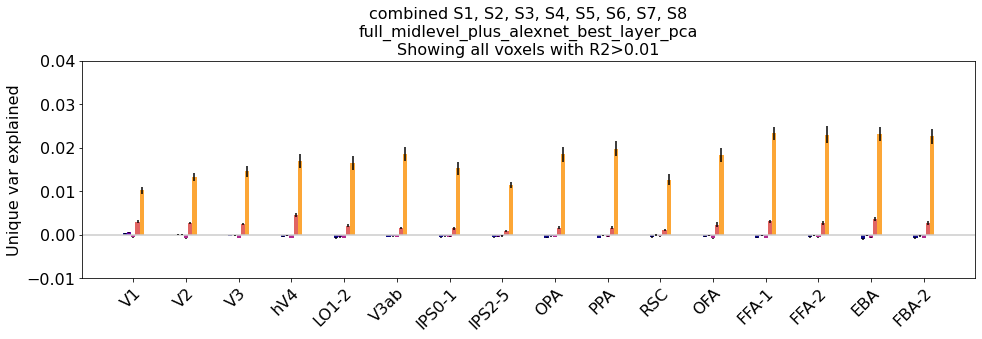

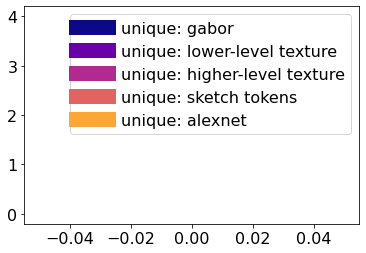

In [9]:
# Make a barplot for variance partition across all ROIs and subjects
roi_names =roi_def.roi_names
r2_thresh = 0.01

# each of these indices is one feature set left out at a time.
ppinds = [2,8,7,10,12]
print(np.array(out[0]['partial_version_names'])[ppinds])
print([np.sum(out[0]['partial_masks'][0][pp,:]==1) for pp in ppinds])
print([np.sum(out[0]['partial_masks'][0][pp,:]==0) for pp in ppinds])
ve_names = ['unique: gabor', 'unique: lower-level texture', \
            'unique: higher-level texture','unique: sketch tokens', \
           'unique: alexnet']

colors = cm.plasma(np.linspace(0,1,6))

vals = np.zeros((n_subjects, n_rois, 5))

for si, ss in enumerate(subjects):
    
    val_r2 = out[si]['val_r2']    
    inds2use = val_r2[:,0]>r2_thresh
    var_expl = np.tile(val_r2[:,0:1], [1,5]) - val_r2[:,ppinds]

    for ri in range(n_rois):
        
        inds_this_roi = roi_def.ss_roi_defs[si].get_indices(ri) & inds2use
        if np.sum(inds_this_roi)==0:
            print('subj %d %s has no voxels'%(ss, roi_names[ri]))
            vals[si,ri,:] = np.nan
        vals[si,ri,:] = np.mean(var_expl[inds_this_roi,:], axis=0)
        
mean_vals = np.mean(vals, axis=0)
sem_vals = np.std(vals, axis=0) / np.sqrt(n_subjects)

legend_separate=True
title='%s\n%s\nShowing all voxels with R2>%.2f'%(summary_plots.get_substr(out), \
                                                                       fitting_type, r2_thresh)

plot_utils.set_all_font_sizes(fs = 16)
fh = plot_utils.plot_multi_bars(mean_data=mean_vals, err_data=sem_vals, colors=colors, space=0.3, \
                xticklabels=roi_names, ylabel='Unique var explained', \
                ylim=[-0.01, 0.040], title=title, horizontal_line_pos=0,\
                legend_labels=ve_names, \
                legend_overlaid=False, legend_separate=legend_separate, \
                fig_size=(16,4))


leave_out_alexnet
just_alexnet


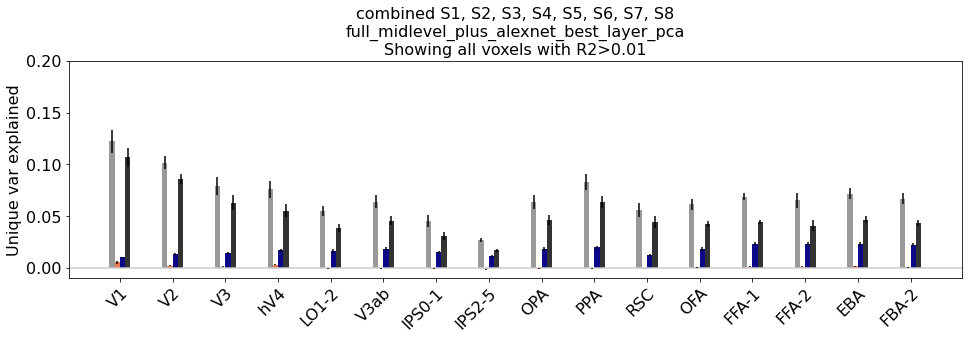

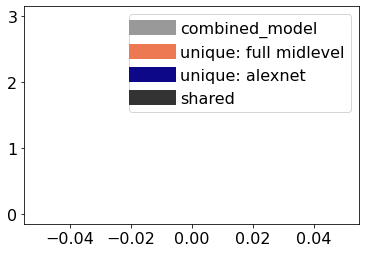

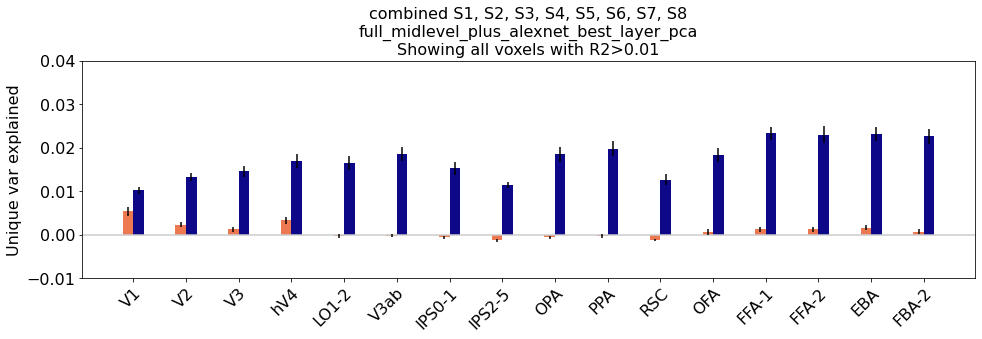

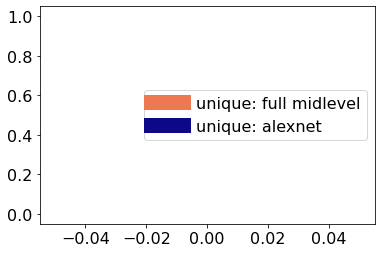

In [10]:
# Make a barplot for variance partition across all ROIs and subjects
roi_names =roi_def.roi_names
r2_thresh = 0.01

pp0 = 0
pp1 = 12
pp2 = 11
print(np.array(out[0]['partial_version_names'][pp1]))
print(np.array(out[0]['partial_version_names'][pp2]))
name1 = 'full midlevel'
name2 = 'alexnet'

ve_names = ['combined_model', 'unique: ' + name1, 'unique: ' + name2, 'shared']

colors = cm.plasma(np.linspace(0,1,4))
colors = np.flipud(colors)
colors = np.concatenate((np.array([[0.6, 0.6, 0.6, 1]]), colors[[1,3],:], np.array([[0.2, 0.2, 0.2, 1]])), axis=0)

vals = np.zeros((n_subjects, n_rois, 4))

for si, ss in enumerate(subjects):
    
    val_r2 = out[si]['val_r2']    
    inds2use = val_r2[:,0]>r2_thresh
    shared_ab, unique_a, unique_b = stats_utils.get_shared_unique_var(val_r2[:,pp0], \
                                                                  val_r2[:,pp1], \
                                                                  val_r2[:,pp2])
    var_expl = np.concatenate((val_r2[:,pp0:pp0+1], unique_a[:,np.newaxis], \
                           unique_b[:,np.newaxis],shared_ab[:,np.newaxis]),axis=1)

    for ri in range(n_rois):
        
        inds_this_roi = roi_def.ss_roi_defs[si].get_indices(ri) & inds2use
        if np.sum(inds_this_roi)==0:
            print('subj %d %s has no voxels'%(ss, roi_names[ri]))
            vals[si,ri,:] = np.nan
        vals[si,ri,:] = np.mean(var_expl[inds_this_roi,:], axis=0)
        
mean_vals = np.mean(vals, axis=0)
sem_vals = np.std(vals, axis=0) / np.sqrt(n_subjects)

legend_separate=True
title='%s\n%s\nShowing all voxels with R2>%.2f'%(summary_plots.get_substr(out), \
                                                                       fitting_type, r2_thresh)

plot_utils.set_all_font_sizes(fs = 16)
fh = plot_utils.plot_multi_bars(mean_data=mean_vals, err_data=sem_vals, colors=colors, space=0.3, \
                xticklabels=roi_names, ylabel='Unique var explained', \
                ylim=[-0.01, 0.20], title=title, horizontal_line_pos=0,\
                legend_labels=ve_names, \
                legend_overlaid=False, legend_separate=legend_separate, \
                fig_size=(16,4))

fh = plot_utils.plot_multi_bars(mean_data=mean_vals[:,[1,2]], err_data=sem_vals[:,[1,2]], \
                                colors=colors[[1,2],:], space=0.3, \
                xticklabels=roi_names, ylabel='Unique var explained', \
                ylim=[-0.01, 0.04], title=title, horizontal_line_pos=0,\
                legend_labels=ve_names[1:3], \
                legend_overlaid=False, legend_separate=legend_separate, \
                fig_size=(16,4))


['leave_out_gabor_solo'
 'pyramid_texture_just_higher-level_plus_other_modules'
 'pyramid_texture_just_lower-level_plus_other_modules'
 'leave_out_sketch_tokens' 'leave_out_alexnet']
[809, 856, 313, 755, 887]
[96, 49, 592, 150, 18]


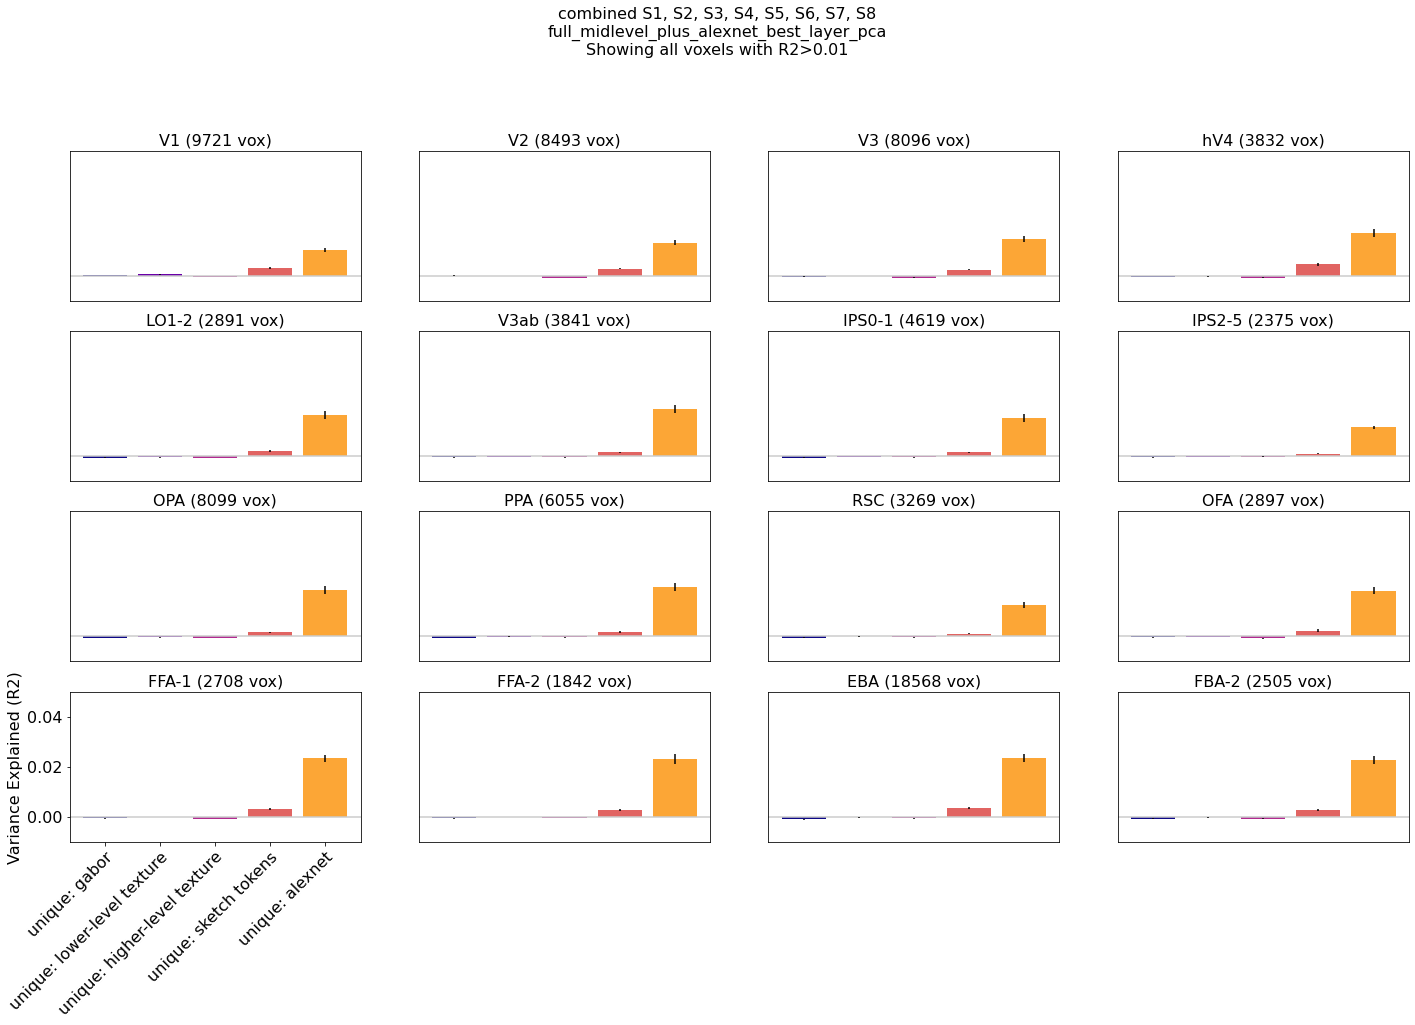

In [13]:

# each of these indices is one feature set left out at a time.
ppinds = [2,8,7,10,12]
print(np.array(out[0]['partial_version_names'])[ppinds])
print([np.sum(out[0]['partial_masks'][0][pp,:]==1) for pp in ppinds])
print([np.sum(out[0]['partial_masks'][0][pp,:]==0) for pp in ppinds])
ve_names = ['unique: gabor', 'unique: lower-level texture', \
            'unique: higher-level texture','unique: sketch tokens', \
           'unique: alexnet']

val_r2 = np.concatenate([o['val_r2'] for o in out], axis=0) 

var_expl = np.tile(val_r2[:,0:1], [1,5]) - val_r2[:,ppinds]

n_vox = [out[si]['val_r2'].shape[0] for si in range(n_subjects)]
subject_inds = np.concatenate([si*np.ones(n_vox[si],) for si in range(n_subjects)])

colors = cm.plasma(np.linspace(0,1,6))
# colors = np.flipud(colors)

r2_thresh = 0.01
inds2use = val_r2[:,0]>r2_thresh

bp = plot_utils.bar_plot(colors=colors, column_labels=ve_names, ylabel='Variance Explained (R2)', \
                                                        horizontal_line_pos=0, ylims=[-0.01, 0.05])
plot_utils.create_roi_subplots(var_expl, inds2use, \
                               subject_inds=subject_inds,\
                               single_plot_object=bp, roi_def=roi_def,\
                    suptitle='%s\n%s\nShowing all voxels with R2>%.2f'%(summary_plots.get_substr(out), \
                                                                       fitting_type, r2_thresh))

plt.gcf().subplots_adjust(bottom=0.4)


leave_out_alexnet
just_alexnet


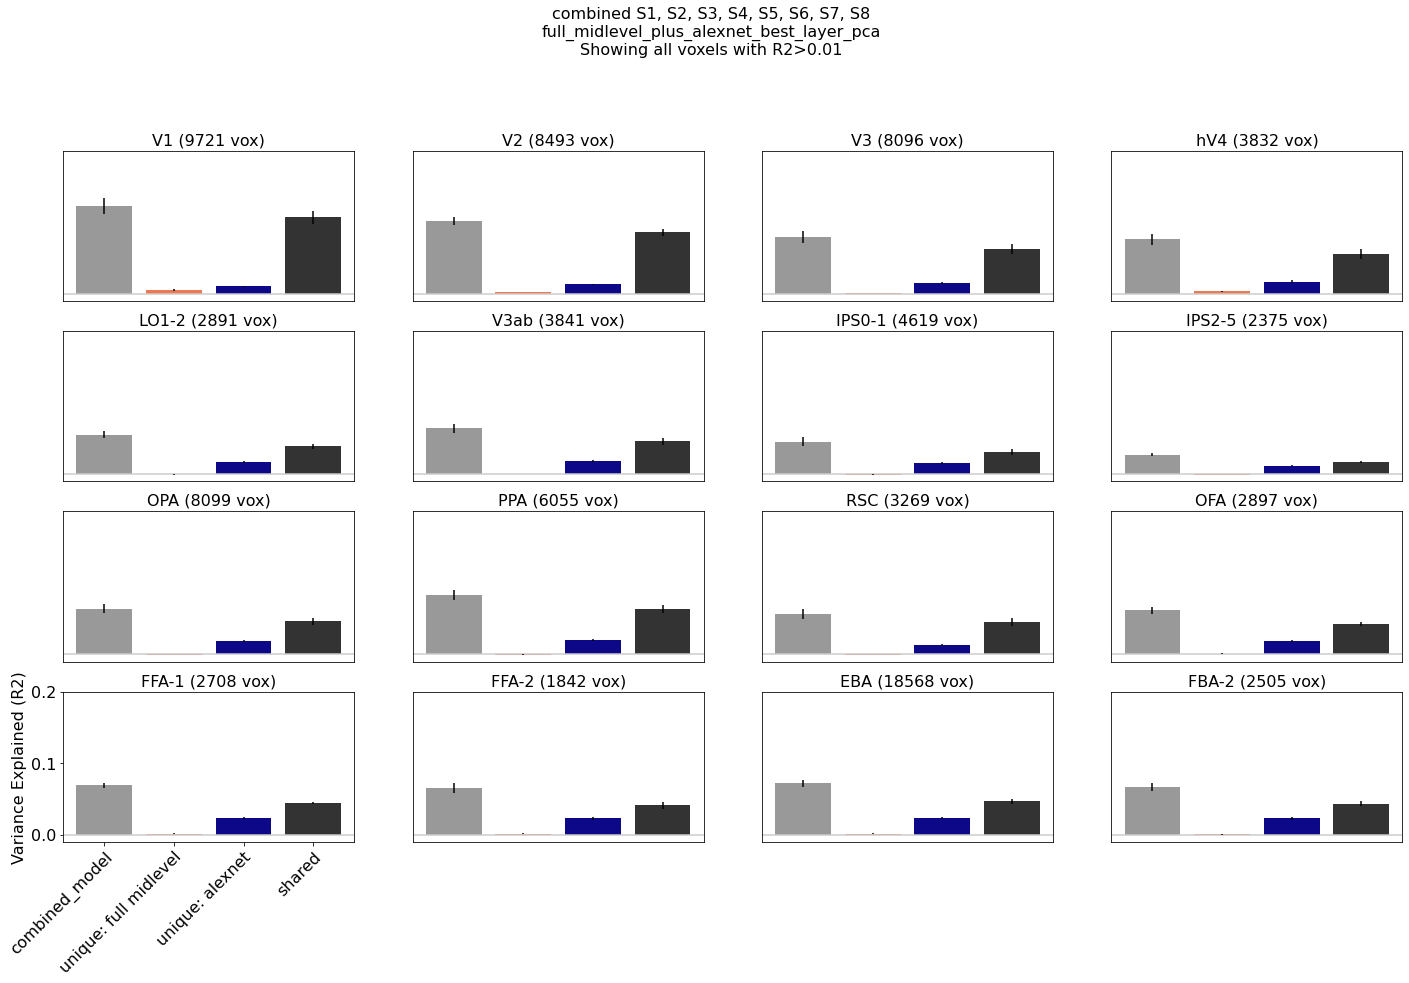

In [14]:
pp0 = 0
pp1 = 12
pp2 = 11
print(np.array(out[0]['partial_version_names'][pp1]))
print(np.array(out[0]['partial_version_names'][pp2]))
name1 = 'full midlevel'
name2 = 'alexnet'

val_r2 = np.concatenate([o['val_r2'] for o in out], axis=0) 


ve_names = ['combined_model', 'unique: ' + name1, 'unique: ' + name2, 'shared']
shared_ab, unique_a, unique_b = stats_utils.get_shared_unique_var(val_r2[:,pp0], \
                                                                  val_r2[:,pp1], \
                                                                  val_r2[:,pp2])

var_expl = np.concatenate((val_r2[:,pp0:pp0+1], unique_a[:,np.newaxis], \
                           unique_b[:,np.newaxis],shared_ab[:,np.newaxis]),axis=1)

colors = cm.plasma(np.linspace(0,1,4))
colors = np.flipud(colors)
colors = np.concatenate((np.array([[0.6, 0.6, 0.6, 1]]), colors[[1,3],:], np.array([[0.2, 0.2, 0.2, 1]])), axis=0)

inds2use = val_r2[:,0]>0.01

n_vox = [out[si]['val_r2'].shape[0] for si in range(n_subjects)]
subject_inds = np.concatenate([si*np.ones(n_vox[si],) for si in range(n_subjects)])


bp = plot_utils.bar_plot(colors=colors, column_labels=ve_names, ylabel='Variance Explained (R2)', \
                                                        horizontal_line_pos=0, ylims=[-0.01, 0.20])
plot_utils.create_roi_subplots(var_expl, inds2use, \
                               subject_inds=subject_inds,\
                               single_plot_object=bp, roi_def=roi_def,\
                    suptitle='%s\n%s\nShowing all voxels with R2>%.2f'%(summary_plots.get_substr(out), \
                                                                       fitting_type, r2_thresh))

plt.gcf().subplots_adjust(bottom=0.4)
